In [9]:
# -*- coding: utf-8 -*-
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set encoding untuk Windows console (hanya jika bukan Jupyter Notebook)
if sys.platform == 'win32' and hasattr(sys.stdout, 'buffer'):
    import io
    sys.stdout = io.TextIOWrapper(sys.stdout.buffer, encoding='utf-8')

# Set style untuk visualisasi
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Path ke dataset
DATASET_PATH = Path("dataset/original_dataset")

def load_dataset_info():
    """
    Mengimport dataset dan menghitung jumlah gambar di setiap folder
    """
    dataset_info = []
    
    # Mendapatkan semua folder kelas
    class_folders = [f for f in DATASET_PATH.iterdir() if f.is_dir()]
    
    print("=" * 80)
    print("INFORMASI DATASET")
    print("=" * 80)
    print(f"Path Dataset: {DATASET_PATH.absolute()}")
    print(f"Jumlah Kelas: {len(class_folders)}")
    print("-" * 80)
    
    # Menghitung jumlah file di setiap kelas
    for folder in sorted(class_folders):
        # Hitung jumlah file gambar
        image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']
        image_files = [f for f in folder.iterdir() 
                      if f.is_file() and f.suffix.lower() in image_extensions]
        
        count = len(image_files)
        class_name = folder.name
        
        dataset_info.append({
            'Kelas': class_name,
            'Jumlah Gambar': count,
            'Path': str(folder)
        })
        
        print(f"{class_name}: {count} gambar")
    
    # Buat DataFrame
    df = pd.DataFrame(dataset_info)
    
    # Statistik keseluruhan
    total_images = df['Jumlah Gambar'].sum()
    avg_images = df['Jumlah Gambar'].mean()
    min_images = df['Jumlah Gambar'].min()
    max_images = df['Jumlah Gambar'].max()
    
    print("-" * 80)
    print(f"Total Gambar: {total_images:,}")
    print(f"Rata-rata per Kelas: {avg_images:.2f}")
    print(f"Minimum: {min_images}")
    print(f"Maximum: {max_images}")
    print("=" * 80)
    
    return df

def visualize_distribution(df):
    """
    Membuat visualisasi penyebaran data
    """
    # Persiapan data untuk visualisasi
    # Bersihkan nama kelas untuk tampilan yang lebih baik
    df_sorted = df.sort_values('Jumlah Gambar', ascending=False).copy()
    
    # Buat singkatan nama kelas untuk sumbu X
    df_sorted['Kelas_Singkat'] = df_sorted['Kelas'].apply(
        lambda x: x.split('.')[1].strip() if '.' in x else x
    )
    
    # Create subplot dengan 2 baris
    fig, axes = plt.subplots(2, 1, figsize=(16, 12))
    
    # Plot 1: Bar chart horizontal dengan warna gradient
    colors = plt.cm.viridis(range(len(df_sorted)))
    bars = axes[0].barh(range(len(df_sorted)), df_sorted['Jumlah Gambar'], color=colors)
    axes[0].set_yticks(range(len(df_sorted)))
    axes[0].set_yticklabels(df_sorted['Kelas_Singkat'], fontsize=10)
    axes[0].set_xlabel('Jumlah Gambar', fontsize=12, fontweight='bold')
    axes[0].set_title('Distribusi Dataset per Kelas (Bar Chart)', 
                     fontsize=14, fontweight='bold', pad=20)
    axes[0].grid(axis='x', alpha=0.3)
    
    # Tambahkan label nilai di setiap bar
    for i, (bar, count) in enumerate(zip(bars, df_sorted['Jumlah Gambar'])):
        axes[0].text(count + 100, i, f'{count:,}', 
                    va='center', fontsize=9, fontweight='bold')
    
    # Plot 2: Pie chart
    # Hanya tampilkan label untuk kelas dengan > 5% data
    total = df_sorted['Jumlah Gambar'].sum()
    percentages = (df_sorted['Jumlah Gambar'] / total) * 100
    
    def autopct_format(pct):
        return f'{pct:.1f}%' if pct > 5 else ''
    
    wedges, texts, autotexts = axes[1].pie(
        df_sorted['Jumlah Gambar'], 
        labels=df_sorted['Kelas_Singkat'],
        autopct=autopct_format,
        startangle=90,
        colors=colors,
        textprops={'fontsize': 9}
    )
    
    # Perbaiki tampilan teks
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(10)
    
    axes[1].set_title('Proporsi Dataset per Kelas (Pie Chart)', 
                     fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    
    # Simpan visualisasi
    output_path = "dataset_distribution.png"
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"\n✓ Visualisasi disimpan di: {output_path}")
    
    plt.show()

def check_data_balance(df):
    """
    Mengecek keseimbangan dataset
    """
    print("\n" + "=" * 80)
    print("ANALISIS KESEIMBANGAN DATA")
    print("=" * 80)
    
    total = df['Jumlah Gambar'].sum()
    
    # Hitung persentase setiap kelas
    df_analysis = df.copy()
    df_analysis['Persentase (%)'] = (df_analysis['Jumlah Gambar'] / total * 100).round(2)
    df_analysis = df_analysis.sort_values('Jumlah Gambar', ascending=False)
    
    print("\nRingkasan Persentase:")
    print("-" * 80)
    for idx, row in df_analysis.iterrows():
        class_name = row['Kelas'].split('.')[1].strip() if '.' in row['Kelas'] else row['Kelas']
        print(f"{class_name:50s} {row['Jumlah Gambar']:6,} ({row['Persentase (%)']:5.2f}%)")
    
    # Deteksi imbalance
    max_pct = df_analysis['Persentase (%)'].max()
    min_pct = df_analysis['Persentase (%)'].min()
    ratio = max_pct / min_pct
    
    print("-" * 80)
    print(f"Rasio Imbalance: {ratio:.2f}:1")
    
    if ratio > 10:
        print("⚠️  Dataset SANGAT TIDAK SEIMBANG - Pertimbangkan teknik resampling")
    elif ratio > 5:
        print("⚠️  Dataset TIDAK SEIMBANG - Mungkin perlu augmentasi")
    elif ratio > 2:
        print("ℹ️  Dataset agak tidak seimbang - Masih dalam batas wajar")
    else:
        print("✓ Dataset relatif seimbang")
    
    print("=" * 80)
    
    return df_analysis

def main():
    """
    Fungsi utama untuk menjalankan semua analisis
    """
    # Cek apakah folder dataset ada
    if not DATASET_PATH.exists():
        print(f"❌ Error: Folder {DATASET_PATH} tidak ditemukan!")
        return
    
    # Load dan tampilkan info dataset
    df = load_dataset_info()
    
    # Analisis keseimbangan
    df_analysis = check_data_balance(df)
    
    # Visualisasi distribusi
    visualize_distribution(df)
    
    # Simpan ringkasan ke CSV
    output_csv = "dataset_summary.csv"
    df_analysis.to_csv(output_csv, index=False)
    print(f"\n✓ Ringkasan dataset disimpan di: {output_csv}")


INFORMASI DATASET
Path Dataset: c:\MY DATA\S2\001 - MY PROJECT\facedet\dataset\original_dataset
Jumlah Kelas: 10
--------------------------------------------------------------------------------
1. Eczema 1677: 1677 gambar
10. Warts Molluscum and other Viral Infections - 2103: 2103 gambar
2. Melanoma 15.75k: 3140 gambar
3. Atopic Dermatitis - 1.25k: 1257 gambar
4. Basal Cell Carcinoma (BCC) 3323: 3323 gambar
5. Melanocytic Nevi (NV) - 7970: 7970 gambar
6. Benign Keratosis-like Lesions (BKL) 2624: 2079 gambar
7. Psoriasis pictures Lichen Planus and related diseases - 2k: 2055 gambar
8. Seborrheic Keratoses and other Benign Tumors - 1.8k: 1847 gambar
9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k: 1702 gambar
--------------------------------------------------------------------------------
Total Gambar: 27,153
Rata-rata per Kelas: 2715.30
Minimum: 1257
Maximum: 7970

ANALISIS KESEIMBANGAN DATA

Ringkasan Persentase:
--------------------------------------------------------

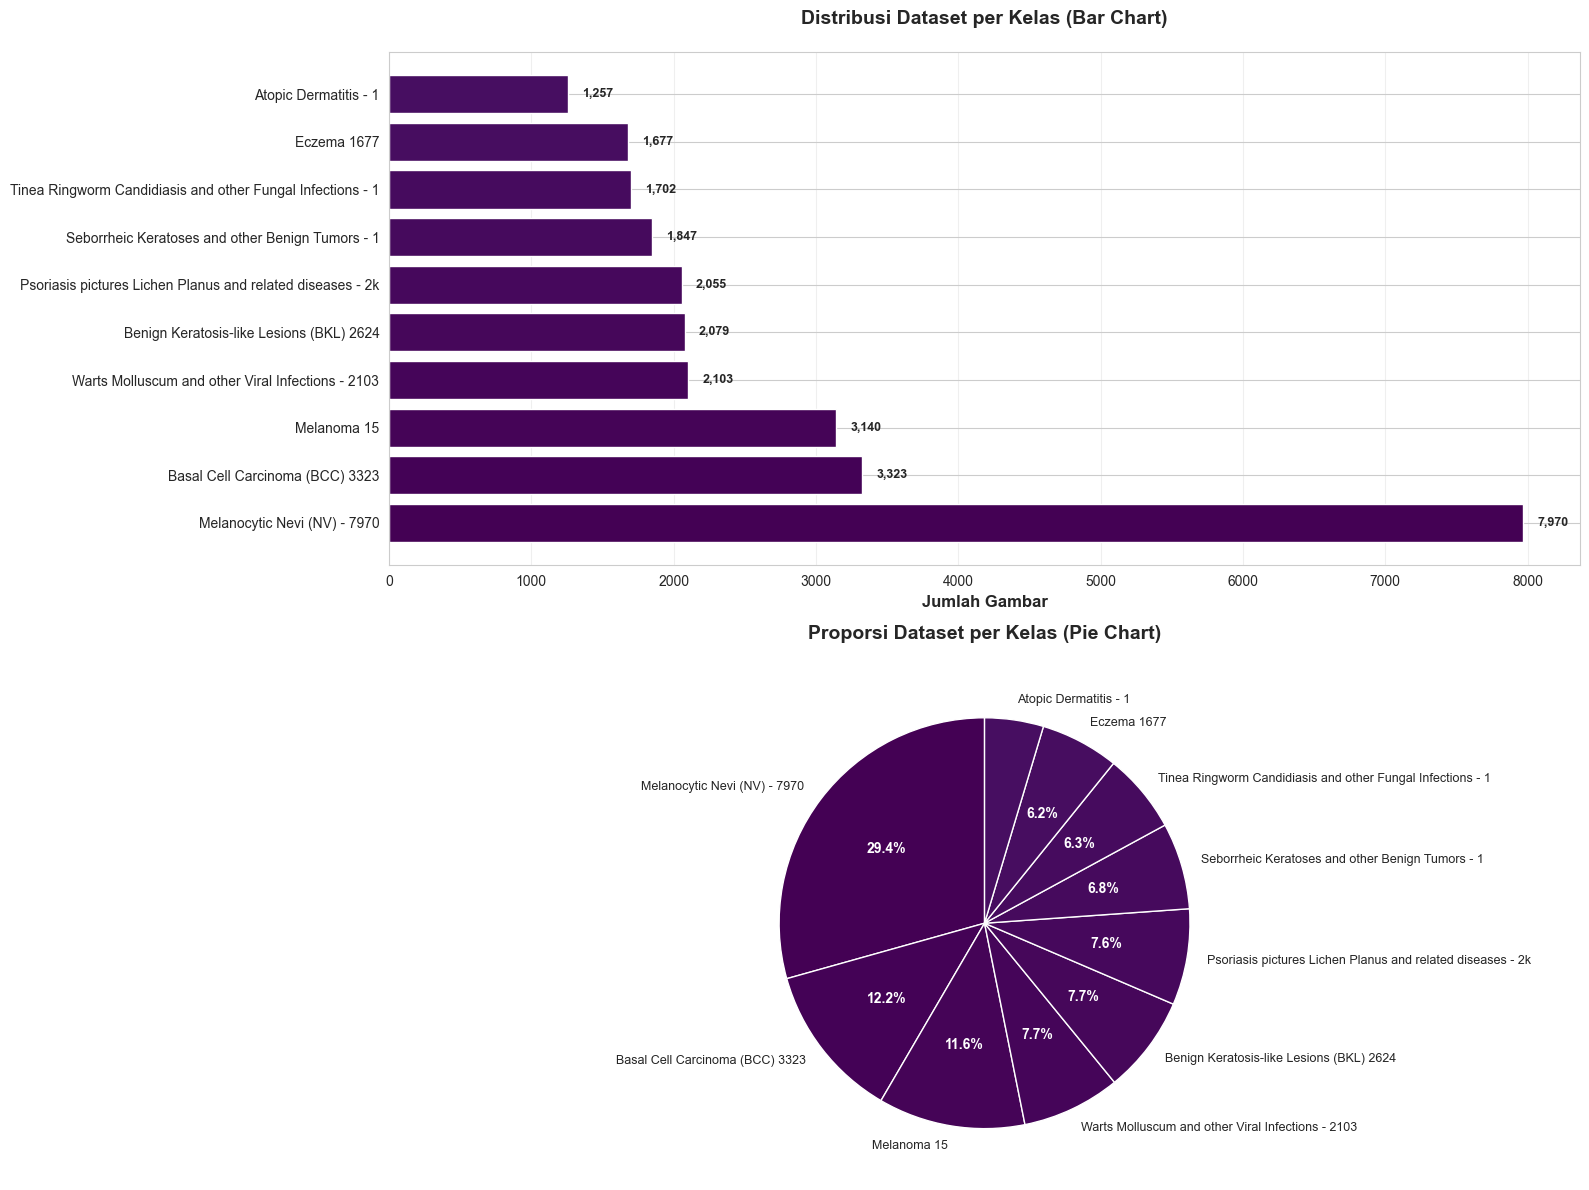


✓ Ringkasan dataset disimpan di: dataset_summary.csv


In [10]:
if __name__ == "__main__":
    main()

In [11]:
# Praproses
# -*- coding: utf-8 -*-
"""
========================================================================================
SCRIPT PREPROCESSING IMAGE UNTUK KLASIFIKASI PENYAKIT KULIT
========================================================================================
Tahapan Preprocessing:
1. Denoising      - Menghilangkan gangguan visual
2. Resizing       - Menyamakan format input model
3. Enhancement    - Memperjelas fitur (CLAHE)
4. Augmentation   - Menambah variasi data (hanya training)
5. Normalization  - Menyetabilkan perhitungan matematis model
========================================================================================
"""

import os
import sys
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import shutil

# Konfigurasi Output untuk Jupyter Notebook
import warnings
warnings.filterwarnings('ignore')


# ========================================================================================
# KONFIGURASI GLOBAL
# ========================================================================================

class Config:
    """Konfigurasi untuk preprocessing"""
    
    # Path dataset
    INPUT_DIR = Path("dataset/original_dataset")
    OUTPUT_DIR = Path("dataset/praproses_result")
    
    # Parameter preprocessing
    TARGET_SIZE = (224, 224)  # Ukuran standar untuk model CNN
    
    # Denoising parameters
    DENOISE_H = 10  # Filter strength for luminance
    DENOISE_H_COLOR = 10  # Filter strength for color
    DENOISE_TEMPLATE_SIZE = 7  # Template patch size
    DENOISE_SEARCH_SIZE = 21  # Search window size
    
    # CLAHE parameters (Contrast Limited Adaptive Histogram Equalization)
    CLAHE_CLIP_LIMIT = 2.0
    CLAHE_TILE_SIZE = (8, 8)
    
    # Augmentation parameters (untuk training)
    AUGMENTATION_ENABLED = True
    AUGMENTATION_FACTOR = 2  # Berapa kali augmentasi per gambar
    
    # Normalization parameters
    NORMALIZE_MEAN = [0.485, 0.456, 0.406]  # ImageNet mean
    NORMALIZE_STD = [0.229, 0.224, 0.225]   # ImageNet std


# ========================================================================================
# 📊 TAHAP 1: DENOISING - Menghilangkan Gangguan Visual
# ========================================================================================

def denoise_image(image):
    """
    Menghilangkan noise dari gambar menggunakan Non-Local Means Denoising
    
    Args:
        image: Image array (BGR format)
    
    Returns:
        Denoised image
    """
    # Gunakan fastNlMeansDenoisingColored untuk gambar berwarna
    denoised = cv2.fastNlMeansDenoisingColored(
        image,
        None,
        h=Config.DENOISE_H,
        hColor=Config.DENOISE_H_COLOR,
        templateWindowSize=Config.DENOISE_TEMPLATE_SIZE,
        searchWindowSize=Config.DENOISE_SEARCH_SIZE
    )
    return denoised


def process_denoising(input_dir, output_dir):
    """
    Proses denoising untuk semua gambar dalam dataset
    
    Returns:
        Dictionary berisi statistik proses
    """
    print("\n" + "="*80)
    print("📍 TAHAP 1/5: DENOISING - Menghilangkan Gangguan Visual")
    print("="*80)
    
    stats = {
        'total_images': 0,
        'processed': 0,
        'failed': 0,
        'classes': []
    }
    
    # Buat direktori output
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Dapatkan semua kelas
    class_folders = sorted([f for f in input_dir.iterdir() if f.is_dir()])
    
    # Hitung total gambar untuk progress bar
    total_images = 0
    for class_folder in class_folders:
        image_files = list(class_folder.glob('*.jpg')) + list(class_folder.glob('*.jpeg')) + \
                      list(class_folder.glob('*.png')) + list(class_folder.glob('*.bmp'))
        total_images += len(image_files)
    
    stats['total_images'] = total_images
    
    # Progress bar untuk seluruh proses
    pbar = tqdm(total=total_images, desc="🔄 Denoising Progress", 
                unit="img", colour="blue")
    
    for class_folder in class_folders:
        class_name = class_folder.name
        stats['classes'].append(class_name)
        
        # Buat folder output untuk kelas ini
        output_class_dir = output_dir / class_name
        output_class_dir.mkdir(parents=True, exist_ok=True)
        
        # Proses setiap gambar
        image_files = list(class_folder.glob('*.jpg')) + list(class_folder.glob('*.jpeg')) + \
                      list(class_folder.glob('*.png')) + list(class_folder.glob('*.bmp'))
        
        for img_path in image_files:
            try:
                # Baca gambar
                image = cv2.imread(str(img_path))
                
                if image is None:
                    stats['failed'] += 1
                    pbar.update(1)
                    continue
                
                # Terapkan denoising
                denoised = denoise_image(image)
                
                # Simpan hasil
                output_path = output_class_dir / img_path.name
                cv2.imwrite(str(output_path), denoised)
                
                stats['processed'] += 1
                
            except Exception as e:
                stats['failed'] += 1
                print(f"\n⚠️ Error processing {img_path.name}: {str(e)}")
            
            pbar.update(1)
    
    pbar.close()
    
    # Tampilkan ringkasan
    print(f"\n✅ Denoising selesai!")
    print(f"   📊 Total: {stats['total_images']} | Berhasil: {stats['processed']} | Gagal: {stats['failed']}")
    print(f"   💾 Output: {output_dir}")
    
    return stats


# ========================================================================================
# 📏 TAHAP 2: RESIZING - Menyamakan Format Input Model
# ========================================================================================

def resize_image(image, target_size=Config.TARGET_SIZE):
    """
    Resize gambar ke ukuran target dengan mempertahankan aspect ratio
    
    Args:
        image: Image array
        target_size: Tuple (width, height)
    
    Returns:
        Resized image
    """
    # Resize dengan interpolasi INTER_AREA untuk downscaling (lebih baik)
    resized = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)
    return resized


def process_resizing(input_dir, output_dir):
    """
    Proses resizing untuk semua gambar
    """
    print("\n" + "="*80)
    print(f"📍 TAHAP 2/5: RESIZING - Menyamakan Format ke {Config.TARGET_SIZE}")
    print("="*80)
    
    stats = {
        'total_images': 0,
        'processed': 0,
        'failed': 0
    }
    
    # Buat direktori output
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Dapatkan semua kelas
    class_folders = sorted([f for f in input_dir.iterdir() if f.is_dir()])
    
    # Hitung total gambar
    total_images = 0
    for class_folder in class_folders:
        image_files = list(class_folder.glob('*.jpg')) + list(class_folder.glob('*.jpeg')) + \
                      list(class_folder.glob('*.png')) + list(class_folder.glob('*.bmp'))
        total_images += len(image_files)
    
    stats['total_images'] = total_images
    
    # Progress bar
    pbar = tqdm(total=total_images, desc="📐 Resizing Progress", 
                unit="img", colour="green")
    
    for class_folder in class_folders:
        class_name = class_folder.name
        
        # Buat folder output
        output_class_dir = output_dir / class_name
        output_class_dir.mkdir(parents=True, exist_ok=True)
        
        # Proses gambar
        image_files = list(class_folder.glob('*.jpg')) + list(class_folder.glob('*.jpeg')) + \
                      list(class_folder.glob('*.png')) + list(class_folder.glob('*.bmp'))
        
        for img_path in image_files:
            try:
                # Baca gambar
                image = cv2.imread(str(img_path))
                
                if image is None:
                    stats['failed'] += 1
                    pbar.update(1)
                    continue
                
                # Resize
                resized = resize_image(image)
                
                # Simpan
                output_path = output_class_dir / img_path.name
                cv2.imwrite(str(output_path), resized)
                
                stats['processed'] += 1
                
            except Exception as e:
                stats['failed'] += 1
                print(f"\n⚠️ Error resizing {img_path.name}: {str(e)}")
            
            pbar.update(1)
    
    pbar.close()
    
    print(f"\n✅ Resizing selesai!")
    print(f"   📊 Total: {stats['total_images']} | Berhasil: {stats['processed']} | Gagal: {stats['failed']}")
    print(f"   💾 Output: {output_dir}")
    
    return stats


# ========================================================================================
# ✨ TAHAP 3: ENHANCEMENT - Memperjelas Fitur dengan CLAHE
# ========================================================================================

def enhance_image_clahe(image):
    """
    Enhance gambar menggunakan CLAHE (Contrast Limited Adaptive Histogram Equalization)
    
    Args:
        image: Image array (BGR format)
    
    Returns:
        Enhanced image
    """
    # Konversi ke LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    
    # Split channels
    l, a, b = cv2.split(lab)
    
    # Apply CLAHE pada L channel
    clahe = cv2.createCLAHE(
        clipLimit=Config.CLAHE_CLIP_LIMIT,
        tileGridSize=Config.CLAHE_TILE_SIZE
    )
    l_clahe = clahe.apply(l)
    
    # Merge kembali
    lab_clahe = cv2.merge([l_clahe, a, b])
    
    # Konversi kembali ke BGR
    enhanced = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)
    
    return enhanced


def process_enhancement(input_dir, output_dir):
    """
    Proses enhancement untuk semua gambar
    """
    print("\n" + "="*80)
    print("📍 TAHAP 3/5: ENHANCEMENT - Memperjelas Fitur dengan CLAHE")
    print("="*80)
    
    stats = {
        'total_images': 0,
        'processed': 0,
        'failed': 0
    }
    
    # Buat direktori output
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Dapatkan semua kelas
    class_folders = sorted([f for f in input_dir.iterdir() if f.is_dir()])
    
    # Hitung total gambar
    total_images = 0
    for class_folder in class_folders:
        image_files = list(class_folder.glob('*.jpg')) + list(class_folder.glob('*.jpeg')) + \
                      list(class_folder.glob('*.png')) + list(class_folder.glob('*.bmp'))
        total_images += len(image_files)
    
    stats['total_images'] = total_images
    
    # Progress bar
    pbar = tqdm(total=total_images, desc="✨ Enhancement Progress", 
                unit="img", colour="yellow")
    
    for class_folder in class_folders:
        class_name = class_folder.name
        
        # Buat folder output
        output_class_dir = output_dir / class_name
        output_class_dir.mkdir(parents=True, exist_ok=True)
        
        # Proses gambar
        image_files = list(class_folder.glob('*.jpg')) + list(class_folder.glob('*.jpeg')) + \
                      list(class_folder.glob('*.png')) + list(class_folder.glob('*.bmp'))
        
        for img_path in image_files:
            try:
                # Baca gambar
                image = cv2.imread(str(img_path))
                
                if image is None:
                    stats['failed'] += 1
                    pbar.update(1)
                    continue
                
                # Enhancement
                enhanced = enhance_image_clahe(image)
                
                # Simpan
                output_path = output_class_dir / img_path.name
                cv2.imwrite(str(output_path), enhanced)
                
                stats['processed'] += 1
                
            except Exception as e:
                stats['failed'] += 1
                print(f"\n⚠️ Error enhancing {img_path.name}: {str(e)}")
            
            pbar.update(1)
    
    pbar.close()
    
    print(f"\n✅ Enhancement selesai!")
    print(f"   📊 Total: {stats['total_images']} | Berhasil: {stats['processed']} | Gagal: {stats['failed']}")
    print(f"   💾 Output: {output_dir}")
    
    return stats


# ========================================================================================
# 🔄 TAHAP 4: AUGMENTATION - Menambah Variasi Data (Training Only)
# ========================================================================================

def augment_image(image, augment_type='flip'):
    """
    Augmentasi gambar dengan berbagai transformasi
    
    Args:
        image: Image array
        augment_type: Tipe augmentasi ('flip', 'rotate', 'brightness', 'zoom')
    
    Returns:
        Augmented image
    """
    if augment_type == 'flip_horizontal':
        return cv2.flip(image, 1)
    
    elif augment_type == 'flip_vertical':
        return cv2.flip(image, 0)
    
    elif augment_type == 'rotate_90':
        return cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    
    elif augment_type == 'rotate_180':
        return cv2.rotate(image, cv2.ROTATE_180)
    
    elif augment_type == 'rotate_270':
        return cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    
    elif augment_type == 'brightness_increase':
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        hsv[:, :, 2] = cv2.add(hsv[:, :, 2], 30)  # Increase brightness
        return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    elif augment_type == 'brightness_decrease':
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        hsv[:, :, 2] = cv2.subtract(hsv[:, :, 2], 30)  # Decrease brightness
        return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    else:
        return image


def process_augmentation(input_dir, output_dir):
    """
    Proses augmentasi untuk menambah variasi data
    """
    print("\n" + "="*80)
    print("📍 TAHAP 4/5: AUGMENTATION - Menambah Variasi Data")
    print("="*80)
    
    if not Config.AUGMENTATION_ENABLED:
        print("⏭️  Augmentasi dinonaktifkan (set AUGMENTATION_ENABLED=True untuk mengaktifkan)")
        return {'skipped': True}
    
    stats = {
        'total_images': 0,
        'augmented_images': 0,
        'processed': 0,
        'failed': 0
    }
    
    # Buat direktori output
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Tipe augmentasi yang akan diterapkan
    augmentation_types = [
        'flip_horizontal',
        'rotate_90',
        'brightness_increase',
        'brightness_decrease'
    ]
    
    # Dapatkan semua kelas
    class_folders = sorted([f for f in input_dir.iterdir() if f.is_dir()])
    
    # Hitung total gambar original
    total_images = 0
    for class_folder in class_folders:
        image_files = list(class_folder.glob('*.jpg')) + list(class_folder.glob('*.jpeg')) + \
                      list(class_folder.glob('*.png')) + list(class_folder.glob('*.bmp'))
        total_images += len(image_files)
    
    stats['total_images'] = total_images
    
    # Total operasi = original + augmented
    total_operations = total_images * (1 + len(augmentation_types))
    
    # Progress bar
    pbar = tqdm(total=total_operations, desc="🔄 Augmentation Progress", 
                unit="img", colour="magenta")
    
    for class_folder in class_folders:
        class_name = class_folder.name
        
        # Buat folder output
        output_class_dir = output_dir / class_name
        output_class_dir.mkdir(parents=True, exist_ok=True)
        
        # Proses gambar
        image_files = list(class_folder.glob('*.jpg')) + list(class_folder.glob('*.jpeg')) + \
                      list(class_folder.glob('*.png')) + list(class_folder.glob('*.bmp'))
        
        for img_path in image_files:
            try:
                # Baca gambar original
                image = cv2.imread(str(img_path))
                
                if image is None:
                    stats['failed'] += 1
                    pbar.update(1 + len(augmentation_types))
                    continue
                
                # Simpan original
                output_path = output_class_dir / img_path.name
                cv2.imwrite(str(output_path), image)
                stats['processed'] += 1
                pbar.update(1)
                
                # Buat augmentasi
                for i, aug_type in enumerate(augmentation_types):
                    augmented = augment_image(image, aug_type)
                    
                    # Buat nama file baru
                    stem = img_path.stem
                    suffix = img_path.suffix
                    aug_filename = f"{stem}_aug_{aug_type}{suffix}"
                    
                    # Simpan augmented
                    aug_output_path = output_class_dir / aug_filename
                    cv2.imwrite(str(aug_output_path), augmented)
                    
                    stats['augmented_images'] += 1
                    pbar.update(1)
                
            except Exception as e:
                stats['failed'] += 1
                print(f"\n⚠️ Error augmenting {img_path.name}: {str(e)}")
                pbar.update(1 + len(augmentation_types))
    
    pbar.close()
    
    print(f"\n✅ Augmentation selesai!")
    print(f"   📊 Original: {stats['processed']} | Augmented: {stats['augmented_images']} | Total: {stats['processed'] + stats['augmented_images']}")
    print(f"   💾 Output: {output_dir}")
    
    return stats


# ========================================================================================
# 📊 TAHAP 5: NORMALIZATION - Menyetabilkan Perhitungan Matematis
# ========================================================================================

def normalize_image(image):
    """
    Normalisasi gambar menggunakan ImageNet mean dan std
    
    Args:
        image: Image array (BGR format)
    
    Returns:
        Normalized image (float32, range -1 to 1)
    """
    # Konversi ke RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Konversi ke float dan scale ke [0, 1]
    image_float = image_rgb.astype(np.float32) / 255.0
    
    # Normalisasi dengan ImageNet mean dan std
    mean = np.array(Config.NORMALIZE_MEAN, dtype=np.float32)
    std = np.array(Config.NORMALIZE_STD, dtype=np.float32)
    
    normalized = (image_float - mean) / std
    
    return normalized


def save_normalized_data(input_dir, output_file):
    """
    Simpan data yang sudah dinormalisasi ke dalam format .npz
    
    Args:
        input_dir: Direktori input dengan gambar yang sudah dipreprocess
        output_file: Path file output .npz
    """
    print("\n" + "="*80)
    print("📍 TAHAP 5/5: NORMALIZATION - Menyetabilkan Perhitungan Matematis")
    print("="*80)
    
    # Data containers
    X_data = []
    y_data = []
    class_names = []
    
    # Dapatkan semua kelas
    class_folders = sorted([f for f in input_dir.iterdir() if f.is_dir()])
    
    # Mapping kelas ke index
    class_to_idx = {folder.name: idx for idx, folder in enumerate(class_folders)}
    class_names = [folder.name for folder in class_folders]
    
    # Hitung total gambar
    total_images = 0
    for class_folder in class_folders:
        image_files = list(class_folder.glob('*.jpg')) + list(class_folder.glob('*.jpeg')) + \
                      list(class_folder.glob('*.png')) + list(class_folder.glob('*.bmp'))
        total_images += len(image_files)
    
    # Progress bar
    pbar = tqdm(total=total_images, desc="📊 Normalization Progress", 
                unit="img", colour="cyan")
    
    processed = 0
    failed = 0
    
    for class_folder in class_folders:
        class_name = class_folder.name
        class_idx = class_to_idx[class_name]
        
        # Proses gambar
        image_files = list(class_folder.glob('*.jpg')) + list(class_folder.glob('*.jpeg')) + \
                      list(class_folder.glob('*.png')) + list(class_folder.glob('*.bmp'))
        
        for img_path in image_files:
            try:
                # Baca gambar
                image = cv2.imread(str(img_path))
                
                if image is None:
                    failed += 1
                    pbar.update(1)
                    continue
                
                # Normalisasi
                normalized = normalize_image(image)
                
                # Simpan ke list
                X_data.append(normalized)
                y_data.append(class_idx)
                
                processed += 1
                
            except Exception as e:
                failed += 1
                print(f"\n⚠️ Error normalizing {img_path.name}: {str(e)}")
            
            pbar.update(1)
    
    pbar.close()
    
    # Konversi ke numpy arrays
    X_data = np.array(X_data, dtype=np.float32)
    y_data = np.array(y_data, dtype=np.int32)
    
    # Simpan ke file .npz
    output_path = Path(output_file)
    output_path.parent.mkdir(parents=True, exist_ok=True)
    
    np.savez_compressed(
        output_path,
        X=X_data,
        y=y_data,
        class_names=class_names,
        class_to_idx=class_to_idx
    )
    
    print(f"\n✅ Normalization selesai!")
    print(f"   📊 Total: {total_images} | Berhasil: {processed} | Gagal: {failed}")
    print(f"   📦 Data shape: X={X_data.shape}, y={y_data.shape}")
    print(f"   💾 Output: {output_path}")
    
    return {
        'total_images': total_images,
        'processed': processed,
        'failed': failed,
        'X_shape': X_data.shape,
        'y_shape': y_data.shape,
        'num_classes': len(class_names),
        'class_names': class_names
    }


# ========================================================================================
# 🚀 FUNGSI UTAMA - Menjalankan Semua Tahap Preprocessing
# ========================================================================================

def run_full_preprocessing(visualize_samples=True):
    """
    Menjalankan semua tahap preprocessing secara berurutan
    
    Args:
        visualize_samples: Apakah akan menampilkan sample hasil preprocessing
    
    Returns:
        Dictionary berisi semua statistik
    """
    print("\n" + "="*80)
    print("🚀 MEMULAI PREPROCESSING PIPELINE")
    print("="*80)
    print(f"📂 Input: {Config.INPUT_DIR}")
    print(f"📂 Output: {Config.OUTPUT_DIR}")
    print(f"🎯 Target Size: {Config.TARGET_SIZE}")
    print(f"🔄 Augmentation: {'Enabled' if Config.AUGMENTATION_ENABLED else 'Disabled'}")
    print("="*80)
    
    all_stats = {}
    
    # Direktori sementara untuk setiap tahap
    temp_dirs = {
        'denoised': Config.OUTPUT_DIR / 'temp_1_denoised',
        'resized': Config.OUTPUT_DIR / 'temp_2_resized',
        'enhanced': Config.OUTPUT_DIR / 'temp_3_enhanced',
        'augmented': Config.OUTPUT_DIR / 'temp_4_augmented'
    }
    
    try:
        # TAHAP 1: Denoising
        all_stats['denoising'] = process_denoising(
            Config.INPUT_DIR,
            temp_dirs['denoised']
        )
        
        # TAHAP 2: Resizing
        all_stats['resizing'] = process_resizing(
            temp_dirs['denoised'],
            temp_dirs['resized']
        )
        
        # TAHAP 3: Enhancement
        all_stats['enhancement'] = process_enhancement(
            temp_dirs['resized'],
            temp_dirs['enhanced']
        )
        
        # TAHAP 4: Augmentation
        all_stats['augmentation'] = process_augmentation(
            temp_dirs['enhanced'],
            temp_dirs['augmented']
        )
        
        # TAHAP 5: Normalization
        all_stats['normalization'] = save_normalized_data(
            temp_dirs['augmented'],
            Config.OUTPUT_DIR / 'preprocessed_data.npz'
        )
        
        # Pindahkan hasil akhir
        final_dir = Config.OUTPUT_DIR / 'final_images'
        if final_dir.exists():
            shutil.rmtree(final_dir)
        shutil.copytree(temp_dirs['augmented'], final_dir)
        
        print("\n" + "="*80)
        print("✅ PREPROCESSING SELESAI!")
        print("="*80)
        
        # Cleanup temporary directories
        print("\n🧹 Membersihkan file sementara...")
        for temp_dir in temp_dirs.values():
            if temp_dir.exists():
                shutil.rmtree(temp_dir)
        print("✅ Cleanup selesai!")
        
        # Summary
        print("\n" + "="*80)
        print("📊 RINGKASAN PREPROCESSING")
        print("="*80)
        
        if 'normalization' in all_stats:
            norm_stats = all_stats['normalization']
            print(f"Total Dataset: {norm_stats['processed']:,} gambar")
            print(f"Jumlah Kelas: {norm_stats['num_classes']}")
            print(f"Shape Data: X={norm_stats['X_shape']}, y={norm_stats['y_shape']}")
            print(f"\nDaftar Kelas:")
            for i, class_name in enumerate(norm_stats['class_names']):
                print(f"  {i}. {class_name}")
        
        print("\n💾 Output Files:")
        print(f"  - Final Images: {final_dir}")
        print(f"  - Normalized Data: {Config.OUTPUT_DIR / 'preprocessed_data.npz'}")
        print("="*80)
        
        # Visualisasi sample (opsional)
        if visualize_samples:
            visualize_preprocessing_samples(final_dir)
        
    except Exception as e:
        print(f"\n❌ Error during preprocessing: {str(e)}")
        raise
    
    return all_stats


# ========================================================================================
# 📸 VISUALISASI SAMPLE HASIL PREPROCESSING
# ========================================================================================

def visualize_preprocessing_samples(processed_dir, num_samples=5):
    """
    Menampilkan sample gambar hasil preprocessing
    """
    print("\n" + "="*80)
    print("📸 VISUALISASI SAMPLE HASIL PREPROCESSING")
    print("="*80)
    
    # Ambil satu kelas secara random
    class_folders = [f for f in processed_dir.iterdir() if f.is_dir()]
    if not class_folders:
        print("⚠️ Tidak ada folder kelas ditemukan")
        return
    
    sample_class = class_folders[0]
    print(f"Menampilkan sample dari kelas: {sample_class.name}")
    
    # Ambil beberapa gambar
    image_files = list(sample_class.glob('*.jpg')) + list(sample_class.glob('*.png'))
    sample_files = image_files[:num_samples]
    
    if not sample_files:
        print("⚠️ Tidak ada gambar ditemukan")
        return
    
    # Buat display
    fig, axes = plt.subplots(1, len(sample_files), figsize=(15, 3))
    
    if len(sample_files) == 1:
        axes = [axes]
    
    for ax, img_path in zip(axes, sample_files):
        img = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        ax.imshow(img_rgb)
        ax.set_title(img_path.stem[:20], fontsize=8)
        ax.axis('off')
    
    plt.tight_layout()
    
    # Simpan visualisasi
    output_path = Config.OUTPUT_DIR / 'sample_visualization.png'
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"\n✅ Visualisasi disimpan di: {output_path}")
    
    plt.show()


# ========================================================================================
# 🎯 MAIN EXECUTION
# ========================================================================================

if __name__ == "__main__":
    # Jalankan preprocessing lengkap
    stats = run_full_preprocessing(visualize_samples=True)


c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



🚀 MEMULAI PREPROCESSING PIPELINE
📂 Input: dataset\original_dataset
📂 Output: dataset\praproses_result
🎯 Target Size: (224, 224)
🔄 Augmentation: Enabled

📍 TAHAP 1/5: DENOISING - Menghilangkan Gangguan Visual


🔄 Denoising Progress:   1%|          | 194/27153 [00:45<2:35:03,  2.90img/s]

KeyboardInterrupt: 